<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 17:55:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.2 MB/s 
     |████████████████████████████████| 133 kB 72.8 MB/s 
     |████████████████████████████████| 170 kB 76.5 MB/s 
     |████████████████████████████████| 138 kB 71.8 MB/s 
     |████████████████████████████████| 97 kB 5.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: fkjmn8w1
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/fkjmn8w1


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: i63qknbb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 22s 155ms/step - loss: 0.0732 - mean_squared_error: 0.0732 - mean_absolute_error: 0.2096 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1243
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0517 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1159
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0441 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1104
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0439 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1078
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_squared_error: 0

epoch,99
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02709
val_loss,0.00881
val_mean_squared_error,0.00881
val_mean_absolute_error,0.07366
_runtime,41
_timestamp,1626717444
_step,99
best_val_loss,0.00858


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ojazzv64 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 13s 148ms/step - loss: 0.1359 - mean_squared_error: 0.1359 - mean_absolute_error: 0.2217 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0915
Epoch 2/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0519 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0886
Epoch 3/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0400 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0875
Epoch 4/100
32/32 [==============================] - 4s 122ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0425 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0807
Epoch 5/100
32/32 [==============================] - 4s 119ms/step - loss: 0.0022 - mean_sq

epoch,35
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.02251
val_loss,0.00555
val_mean_squared_error,0.00555
val_mean_absolute_error,0.05644
_runtime,145
_timestamp,1626717600
_step,35
best_val_loss,0.00547


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▇▄▅▄▃▄▃▂▄▂▃▂▁▃▁▂▁▁▂▁▁▂▁▁▁▁▁▃▁▁▁
val_mean_squared_error,█▇▇▆▅▇▄▅▄▃▄▃▂▄▂▃▂▁▃▁▂▁▁▂▁▁▂▁▁▁▁▁▃▁▁▁
val_mean_absolute_error,█▇▇▆▅▇▅▆▅▄▄▃▃▄▂▄▂▂▄▂▂▂▁▃▁▁▂▁▁▁▁▂▃▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rrh9zfxm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 132ms/step - loss: 0.2572 - mean_squared_error: 0.2572 - mean_absolute_error: 0.4450 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.2051
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1596 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1555
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1288 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1325
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0725 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1084
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0081

epoch,199
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02698
val_loss,0.00866
val_mean_squared_error,0.00866
val_mean_absolute_error,0.07297
_runtime,30
_timestamp,1626717645
_step,199
best_val_loss,0.00866


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6hv4yvkx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 33ms/step - loss: 0.1424 - mean_squared_error: 0.1424 - mean_absolute_error: 0.3035 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1094
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0618 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1024
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0405 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1017
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0379 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1001
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,49
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02678
val_loss,0.00858
val_mean_squared_error,0.00858
val_mean_absolute_error,0.07284
_runtime,23
_timestamp,1626717676
_step,49
best_val_loss,0.00857


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mw23j56s with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 243ms/step - loss: 0.2143 - mean_squared_error: 0.2143 - mean_absolute_error: 0.3644 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1526
Epoch 2/100
8/8 [==============================] - 1s 112ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0776 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1334
Epoch 3/100
8/8 [==============================] - 1s 124ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0646 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1264
Epoch 4/100
8/8 [==============================] - 1s 132ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1170
Epoch 5/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0045 - mean_squared_error

epoch,99
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02749
val_loss,0.00783
val_mean_squared_error,0.00783
val_mean_absolute_error,0.0693
_runtime,107
_timestamp,1626717795
_step,99
best_val_loss,0.00783


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ji3rre4t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 7s 186ms/step - loss: 0.6348 - mean_squared_error: 0.6348 - mean_absolute_error: 0.4791 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1213
Epoch 2/200
16/16 [==============================] - 2s 125ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0796 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1221
Epoch 3/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0788 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1082
Epoch 4/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0614 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1328
Epoch 5/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0133 - mean_squ

epoch,59
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03536
val_loss,0.00713
val_mean_squared_error,0.00713
val_mean_absolute_error,0.06732
_runtime,121
_timestamp,1626717965
_step,59
best_val_loss,0.00547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▆█▆▃▃▃▄▂▂▂▂▂▁▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▅▆█▆▃▃▃▄▂▂▂▂▂▁▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▅▆█▆▃▃▃▅▂▃▂▃▂▂▂▂▃▃▂▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9hh0z1ht with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 9s 152ms/step - loss: 2.8099 - mean_squared_error: 2.8099 - mean_absolute_error: 0.7173 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0909
Epoch 2/100
32/32 [==============================] - 4s 125ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1444 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1163
Epoch 3/100
32/32 [==============================] - 4s 112ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1020 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1158
Epoch 4/100
32/32 [==============================] - 4s 114ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1205 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1146
Epoch 5/100
32/32 [==============================] - 4s 114ms/step - loss: 0.0127 - mean_squ

epoch,25
loss,0.00238
mean_squared_error,0.00238
mean_absolute_error,0.03851
val_loss,0.00631
val_mean_squared_error,0.00631
val_mean_absolute_error,0.06136
_runtime,106
_timestamp,1626718079
_step,25
best_val_loss,0.00547


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅██▇▇▅▃▄▂▂▄▂▂▁▁▁▁▁▁▃▂▁▁▃▁▁
val_mean_squared_error,▅██▇▇▅▃▄▂▂▄▂▂▁▁▁▁▁▁▃▂▁▁▃▁▁
val_mean_absolute_error,▅███▇▆▃▄▂▂▅▃▃▁▁▁▁▁▂▃▂▁▁▄▁▂
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: sx23bug3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 6s 270ms/step - loss: 0.2343 - mean_squared_error: 0.2343 - mean_absolute_error: 0.2975 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1129
Epoch 2/100
8/8 [==============================] - 1s 129ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0601 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1434
Epoch 3/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0761 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1129
Epoch 4/100
8/8 [==============================] - 1s 128ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0685 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1186
Epoch 5/100
8/8 [==============================] - 1s 130ms/step - loss: 0.0096 - mean_squared_error

epoch,99
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02939
val_loss,0.00717
val_mean_squared_error,0.00717
val_mean_absolute_error,0.06534
_runtime,106
_timestamp,1626718237
_step,99
best_val_loss,0.00529


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▆▅▅▄▄▅▆▃▄▃▂▂▃▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▇▇█▆▅▅▄▄▅▆▃▄▃▂▂▃▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,███▆▆▆▅▄▆▆▄▄▃▃▂▄▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▂▁▁▂▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q7vorioi with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 178ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1026 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1015
Epoch 2/100
16/16 [==============================] - 2s 121ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0949
Epoch 3/100
16/16 [==============================] - 2s 117ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0431 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0983
Epoch 4/100
16/16 [==============================] - 2s 120ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0431 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1004
Epoch 5/100
16/16 [==============================] - 2s 121ms/step - loss: 0.0034 - mean_squ

epoch,99
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02215
val_loss,0.00537
val_mean_squared_error,0.00537
val_mean_absolute_error,0.05516
_runtime,203
_timestamp,1626718493
_step,99
best_val_loss,0.00537


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁
val_loss,█▇▆▇▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▃▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▇▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▃▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▇▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▄▂▂▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: raizdzl2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 154ms/step - loss: 0.0742 - mean_squared_error: 0.0742 - mean_absolute_error: 0.1881 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1161
Epoch 2/100
32/32 [==============================] - 4s 124ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0678 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1074
Epoch 3/100
32/32 [==============================] - 4s 118ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0587 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1132
Epoch 4/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1085
Epoch 5/100
32/32 [==============================] - 4s 114ms/step - loss: 0.0049 - mean_squ

epoch,53
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02459
val_loss,0.00667
val_mean_squared_error,0.00667
val_mean_absolute_error,0.06524
_runtime,217
_timestamp,1626718720
_step,53
best_val_loss,0.00625


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▄▄▄▃▃▃▂▂▂▂▂▂▂▂▃▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▇▄▄▄▃▃▃▂▂▂▂▂▂▂▂▃▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5x7791a3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 5s 250ms/step - loss: 0.1828 - mean_squared_error: 0.1828 - mean_absolute_error: 0.3071 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1114
Epoch 2/200
8/8 [==============================] - 1s 132ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0676 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1234
Epoch 3/200
8/8 [==============================] - 1s 122ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0756 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1011
Epoch 4/200
8/8 [==============================] - 1s 137ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0567 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1244
Epoch 5/200
8/8 [==============================] - 1s 133ms/step - loss: 0.0077 - mean_squared_error

epoch,107
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.02509
val_loss,0.00543
val_mean_squared_error,0.00543
val_mean_absolute_error,0.05583
_runtime,116
_timestamp,1626718895
_step,107
best_val_loss,0.0052


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▅▄▄▅▃▄▃▃▃▂▃▂▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5m33s2q7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 6s 176ms/step - loss: 0.1117 - mean_squared_error: 0.1117 - mean_absolute_error: 0.2570 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1551
Epoch 2/200
16/16 [==============================] - 2s 118ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0831 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0951
Epoch 3/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0454 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0939
Epoch 4/200
16/16 [==============================] - 2s 107ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0427 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0929
Epoch 5/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0025 - mean_squ

epoch,92
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.02352
val_loss,0.00591
val_mean_squared_error,0.00591
val_mean_absolute_error,0.05878
_runtime,190
_timestamp,1626719095
_step,92
best_val_loss,0.00578


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: iglj3j7w with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 8s 143ms/step - loss: 0.0812 - mean_squared_error: 0.0812 - mean_absolute_error: 0.1661 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1615
Epoch 2/50
32/32 [==============================] - 4s 121ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0841 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1000
Epoch 3/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0667 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0922
Epoch 4/50
32/32 [==============================] - 4s 122ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0564 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0897
Epoch 5/50
32/32 [==============================] - 4s 114ms/step - loss: 0.0043 - mean_squared_

epoch,42
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02724
val_loss,0.00561
val_mean_squared_error,0.00561
val_mean_absolute_error,0.05774
_runtime,177
_timestamp,1626719298
_step,42
best_val_loss,0.00553


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▂▂▂▂▂▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▂▂▂▂▂▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: rheoya3z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 5s 100ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - mean_absolute_error: 0.1507 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1072
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0721 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1003
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0443 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0972
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0466 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0957
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_

epoch,97
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.02532
val_loss,0.00576
val_mean_squared_error,0.00576
val_mean_absolute_error,0.05715
_runtime,27
_timestamp,1626719334
_step,97
best_val_loss,0.00506


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,█▆▇█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,█▇██▅▄▄▄▄▄▄▃▃▂▂▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▂▂▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0samztmu with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 9s 158ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - mean_absolute_error: 0.1730 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1249
Epoch 2/50
32/32 [==============================] - 4s 133ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0758 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1093
Epoch 3/50
32/32 [==============================] - 4s 125ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0654 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1016
Epoch 4/50
32/32 [==============================] - 4s 129ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1014
Epoch 5/50
32/32 [==============================] - 4s 125ms/step - loss: 0.0030 - mean_squared_

epoch,49
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02652
val_loss,0.00547
val_mean_squared_error,0.00547
val_mean_absolute_error,0.05508
_runtime,205
_timestamp,1626719548
_step,49
best_val_loss,0.00527


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▄▃▃▂▂▃▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▆▅▅▄▃▄▃▃▂▂▃▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▆▆▆▅▄▄▄▄▃▃▄▃▄▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5sgs466o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 9s 150ms/step - loss: 0.1633 - mean_squared_error: 0.1633 - mean_absolute_error: 0.3512 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1434
Epoch 2/50
32/32 [==============================] - 4s 109ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0964 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1046
Epoch 3/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0994
Epoch 4/50
32/32 [==============================] - 4s 122ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0490 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0988
Epoch 5/50
32/32 [==============================] - 4s 131ms/step - loss: 0.0035 - mean_squared_

epoch,49
loss,0.00194
mean_squared_error,0.00194
mean_absolute_error,0.03413
val_loss,0.01021
val_mean_squared_error,0.01021
val_mean_absolute_error,0.07962
_runtime,205
_timestamp,1626719764
_step,49
best_val_loss,0.01021


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kmtqk6ns with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 5s 243ms/step - loss: 25.5270 - mean_squared_error: 25.5270 - mean_absolute_error: 1.5935 - val_loss: 0.1451 - val_mean_squared_error: 0.1451 - val_mean_absolute_error: 0.3056
Epoch 2/50
8/8 [==============================] - 1s 108ms/step - loss: 0.0539 - mean_squared_error: 0.0539 - mean_absolute_error: 0.1841 - val_loss: 0.1192 - val_mean_squared_error: 0.1192 - val_mean_absolute_error: 0.2807
Epoch 3/50
8/8 [==============================] - 1s 108ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1265 - val_loss: 0.1212 - val_mean_squared_error: 0.1212 - val_mean_absolute_error: 0.2836
Epoch 4/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1164 - val_loss: 0.1162 - val_mean_squared_error: 0.1162 - val_mean_absolute_error: 0.2781
Epoch 5/50
8/8 [==============================] - 1s 121ms/step - loss: 0.0193 - mean_squared_error: 0

epoch,46
loss,0.00429
mean_squared_error,0.00429
mean_absolute_error,0.05326
val_loss,0.00979
val_mean_squared_error,0.00979
val_mean_absolute_error,0.07826
_runtime,58
_timestamp,1626719837
_step,46
best_val_loss,0.00611


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▂▂▂▁▂▁▁▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▆▅▄▅▃▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▆▅▄▅▃▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▇▇▆▅▆▄▄▄▃▄▂▂▂▃▃▂▃▁▁▁▂▂▁▂▂▁▂▁▂▁▁▁▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 05c19x13 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 9s 163ms/step - loss: 0.1275 - mean_squared_error: 0.1275 - mean_absolute_error: 0.2856 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1204
Epoch 2/50
32/32 [==============================] - 4s 121ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1030 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1011
Epoch 3/50
32/32 [==============================] - 4s 126ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0771 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0977
Epoch 4/50
32/32 [==============================] - 4s 124ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0685 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0918
Epoch 5/50
32/32 [==============================] - 4s 125ms/step - loss: 0.0060 - mean_squared_

epoch,31
loss,0.00208
mean_squared_error,0.00208
mean_absolute_error,0.03576
val_loss,0.00615
val_mean_squared_error,0.00615
val_mean_absolute_error,0.05967
_runtime,135
_timestamp,1626720012
_step,31
best_val_loss,0.00568


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▄▅▂▃▃▃▂▂▁▂▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▃▄▅▂▃▃▃▂▂▁▂▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▃▃▃▄▅▂▃▃▃▃▂▁▂▃▂▂▂▁▁▂▃▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: eawch4gy with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 7s 191ms/step - loss: 0.1488 - mean_squared_error: 0.1488 - mean_absolute_error: 0.2613 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1110
Epoch 2/50
16/16 [==============================] - 2s 129ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0667 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1048
Epoch 3/50
16/16 [==============================] - 2s 117ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0982
Epoch 4/50
16/16 [==============================] - 2s 118ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0491 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0979
Epoch 5/50
16/16 [==============================] - 2s 124ms/step - loss: 0.0031 - mean_squared_

epoch,49
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02873
val_loss,0.00729
val_mean_squared_error,0.00729
val_mean_absolute_error,0.06651
_runtime,112
_timestamp,1626720134
_step,49
best_val_loss,0.00729


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▄▄▄▄▅▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▄▄▄▄▅▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▆▅▅▅▅▄▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qbcdw1zv with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 8s 148ms/step - loss: 0.1537 - mean_squared_error: 0.1537 - mean_absolute_error: 0.2595 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1104
Epoch 2/50
32/32 [==============================] - 4s 123ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1102
Epoch 3/50
32/32 [==============================] - 4s 117ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0446 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1010
Epoch 4/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0431 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0944
Epoch 5/50
32/32 [==============================] - 4s 115ms/step - loss: 0.0025 - mean_squared_

epoch,49
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.02517
val_loss,0.00719
val_mean_squared_error,0.00719
val_mean_absolute_error,0.0664
_runtime,208
_timestamp,1626720353
_step,49
best_val_loss,0.0071


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▅▅▅▄▄▄▃▃▃▃▃▃▄▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▅▅▅▄▄▄▃▃▃▃▃▃▄▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▅▅▅▅▄▄▄▄▃▃▄▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nyyqgguk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 34ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1315 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0829
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0354 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0769
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0326 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0747
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0356 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0733
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_squared_error:

epoch,49
loss,0.00055
mean_squared_error,0.00055
mean_absolute_error,0.01811
val_loss,0.00527
val_mean_squared_error,0.00527
val_mean_absolute_error,0.05622
_runtime,27
_timestamp,1626720392
_step,49
best_val_loss,0.00511


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▃▃▃▃▂▃▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▄▃▃▃▃▂▃▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▄▄▄▄▃▃▃▃▂▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yq2g1qjb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 6s 176ms/step - loss: 0.1386 - mean_squared_error: 0.1386 - mean_absolute_error: 0.2423 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1328
Epoch 2/100
16/16 [==============================] - 2s 134ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0737 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1303
Epoch 3/100
16/16 [==============================] - 2s 133ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0722 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1168
Epoch 4/100
16/16 [==============================] - 2s 129ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0611 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1032
Epoch 5/100
16/16 [==============================] - 2s 129ms/step - loss: 0.0060 - mean_squ

epoch,85
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.02771
val_loss,0.00594
val_mean_squared_error,0.00594
val_mean_absolute_error,0.05875
_runtime,182
_timestamp,1626720587
_step,85
best_val_loss,0.00592


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vrl8afpp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 7s 199ms/step - loss: 0.2484 - mean_squared_error: 0.2484 - mean_absolute_error: 0.4449 - val_loss: 0.1149 - val_mean_squared_error: 0.1149 - val_mean_absolute_error: 0.2741
Epoch 2/50
16/16 [==============================] - 2s 136ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - mean_absolute_error: 0.1952 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1369
Epoch 3/50
16/16 [==============================] - 2s 134ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0539 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1262
Epoch 4/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0493 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1268
Epoch 5/50
16/16 [==============================] - 2s 136ms/step - loss: 0.0039 - mean_squared_

epoch,49
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03696
val_loss,0.01247
val_mean_squared_error,0.01247
val_mean_absolute_error,0.08736
_runtime,113
_timestamp,1626720711
_step,49
best_val_loss,0.01247


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7vz30u4b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 4s 65ms/step - loss: 0.1880 - mean_squared_error: 0.1880 - mean_absolute_error: 0.3325 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0956
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0626 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0879
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0592 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1310
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0905 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0922
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0093 - mean_squared_error:

epoch,21
loss,0.0042
mean_squared_error,0.0042
mean_absolute_error,0.05235
val_loss,0.0111
val_mean_squared_error,0.0111
val_mean_absolute_error,0.08337
_runtime,14
_timestamp,1626720776
_step,21
best_val_loss,0.0061


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁
val_loss,▄▃█▄▂▃▄▂▂▃▁▁▂▂▁▂▁▂▃▁▃▃
val_mean_squared_error,▄▃█▄▂▃▄▂▂▃▁▁▂▂▁▂▁▂▃▁▃▃
val_mean_absolute_error,▅▄█▄▂▄▄▂▂▄▂▁▂▂▂▂▁▂▄▂▃▃
_runtime,▁▁▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: ct18awuv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 5s 246ms/step - loss: 0.3344 - mean_squared_error: 0.3344 - mean_absolute_error: 0.3936 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1458
Epoch 2/200
8/8 [==============================] - 1s 125ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0869 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1270
Epoch 3/200
8/8 [==============================] - 1s 125ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0911 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1093
Epoch 4/200
8/8 [==============================] - 1s 124ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1101
Epoch 5/200
8/8 [==============================] - 1s 116ms/step - loss: 0.0074 - mean_squared_error

epoch,72
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03303
val_loss,0.00764
val_mean_squared_error,0.00764
val_mean_absolute_error,0.06678
_runtime,85
_timestamp,1626720875
_step,72
best_val_loss,0.00547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▆▅▄▄▃▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▅▅▄▄▄▅▃▃▃▃▃▃▃▂▂▂▃▃▂▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oa6tu9rs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 37ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - mean_absolute_error: 0.1850 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0878
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0379 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0808
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0340 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0786
Epoch 4/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0305 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0783
Epoch 5/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_squared_e

epoch,68
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01961
val_loss,0.00536
val_mean_squared_error,0.00536
val_mean_absolute_error,0.05581
_runtime,35
_timestamp,1626720924
_step,68
best_val_loss,0.00519


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gm93dp5o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 37ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1438 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1249
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0966
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0571 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0914
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0979
Epoch 5/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_erro

epoch,72
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02273
val_loss,0.00551
val_mean_squared_error,0.00551
val_mean_absolute_error,0.05567
_runtime,33
_timestamp,1626720971
_step,72
best_val_loss,0.00506


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▃▃▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▃▃▃▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▃▂▂▂▃▂▂▁▃▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ip9vyffa with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 148ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1365 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1005
Epoch 2/100
32/32 [==============================] - 4s 124ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0490 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0977
Epoch 3/100
32/32 [==============================] - 4s 121ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0445 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0896
Epoch 4/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0367 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0868
Epoch 5/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0024 - mean_squ

epoch,73
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02272
val_loss,0.00528
val_mean_squared_error,0.00528
val_mean_absolute_error,0.05505
_runtime,308
_timestamp,1626721305
_step,73
best_val_loss,0.00519


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g4onkmnq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 9s 155ms/step - loss: 0.1319 - mean_squared_error: 0.1319 - mean_absolute_error: 0.2947 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1180
Epoch 2/50
32/32 [==============================] - 4s 126ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0623 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1038
Epoch 3/50
32/32 [==============================] - 4s 134ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0425 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1027
Epoch 4/50
32/32 [==============================] - 4s 129ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0424 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1009
Epoch 5/50
32/32 [==============================] - 4s 131ms/step - loss: 0.0031 - mean_squared_

epoch,49
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02872
val_loss,0.007
val_mean_squared_error,0.007
val_mean_absolute_error,0.06504
_runtime,212
_timestamp,1626721529
_step,49
best_val_loss,0.007


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ibup54i1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 151ms/step - loss: 0.1323 - mean_squared_error: 0.1323 - mean_absolute_error: 0.2769 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1288
Epoch 2/200
32/32 [==============================] - 4s 117ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1228
Epoch 3/200
32/32 [==============================] - 4s 119ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0501 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1212
Epoch 4/200
32/32 [==============================] - 4s 122ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1167
Epoch 5/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0039 - mean_squ

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
40/40 [==============================] - 4s 6ms/step - loss: 0.0408
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 5/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 8/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 9/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 10/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 11/50
40/40 [==============================] - 0s 6ms/step - loss: 9.4804e-04
Epoch 12/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 13/50
40/40 [==========================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

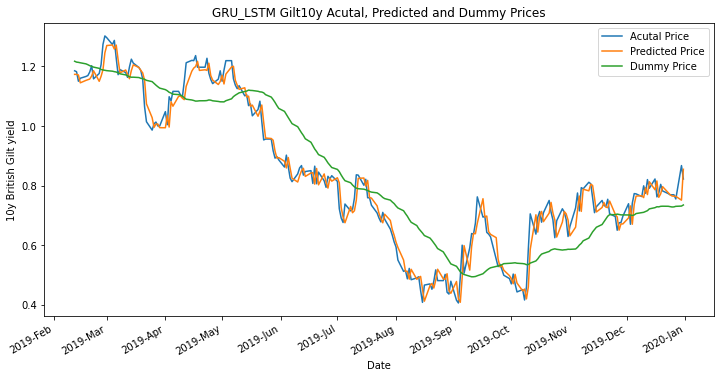

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

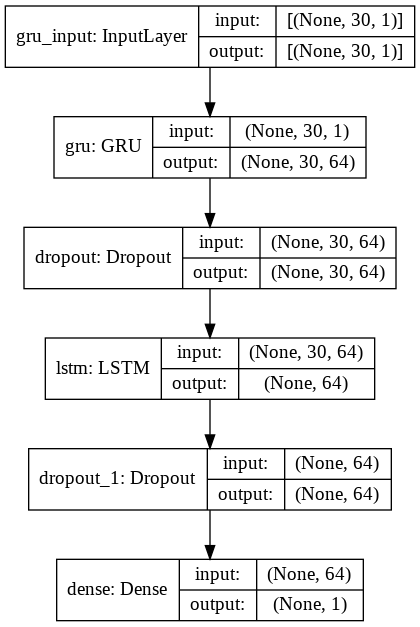

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.002990232998150982
RMSE:  0.05468302294269202
MAE:  0.04348354846994752
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Gilt10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Gilt10y/assets
